<a href="https://colab.research.google.com/github/applejxd/colaboratory/blob/master/ml/torch/mnist_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST で VAE

## 事前確認

バージョンチェック

In [1]:
import torch

print(f"torch.__version__={torch.__version__}")
print(f"torch.cuda.is_available()={torch.cuda.is_available()}\n")

print(f"torch.cuda.device_count()={torch.cuda.is_available()}")
print(f"torch.cuda.current_device()={torch.cuda.is_available()}")
print(f"torch.cuda.device(0)={torch.cuda.device(0)}\n")

if torch.cuda.is_available():
    print(f"torch.cuda.get_device_name(0)={torch.cuda.get_device_name(0)}")
    print(f"torch.cuda.get_device_capability()={torch.cuda.get_device_capability()}")

torch.__version__=2.1.0+cu118
torch.cuda.is_available()=True

torch.cuda.device_count()=True
torch.cuda.current_device()=True
torch.cuda.device(0)=<torch.cuda.device object at 0x7aee82674e50>

torch.cuda.get_device_name(0)=Tesla T4
torch.cuda.get_device_capability()=(7, 5)


[使用するデバイスを確認](https://colab.research.google.com/notebooks/pro.ipynb#scrollTo=23TOba33L4qf)

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Nov 10 23:25:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

seed の固定。deterministic は処理低下を起こすため注意。

In [3]:
import random
import numpy as np

def torch_fix_seed(seed=42):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms = True

torch_fix_seed()

Tensorboard の用意

In [4]:
from torch.utils.tensorboard import SummaryWriter

# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

## データセットの用意

データの読み込み

In [5]:
%%capture
from torchvision import datasets, transforms

transform=transforms.Compose([
    transforms.ToTensor()
])
dataset1 = datasets.MNIST(
    '../data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST(
    '../data', train=False, transform=transform)

データの可視化

shape=(60000, 28, 28)
answer=5


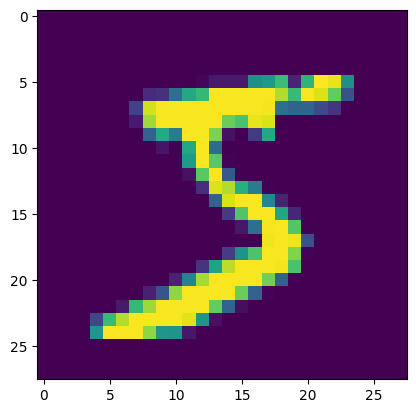

In [6]:
import matplotlib.pyplot as plt

dataset1_data = dataset1.data.numpy()
dataset1_targets = dataset1.targets.numpy()

print(f"shape={dataset1_data.shape}")
print(f"answer={dataset1_targets[0]}")

img = dataset1_data[0]
plt.imshow(img)

複数の画像を一括プロットしてみる

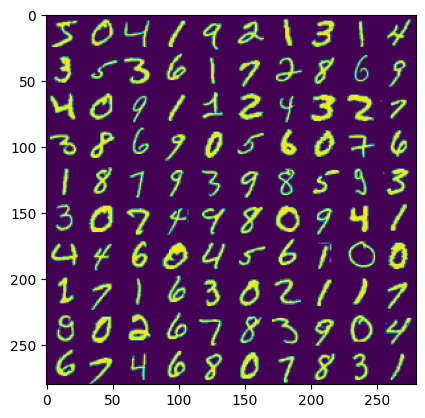

In [7]:
def plot_images(n, img_size=28):
    united_img = np.empty(shape=(img_size*n, img_size*n))
    for i in range(n):
        for j in range(n):
            united_img[img_size*i:img_size*(i+1), img_size*j:img_size*(j+1)] = (
                dataset1_data[i*n+j]
            )
    plt.imshow(united_img)

plot_images(10)

データローダの作成。
[高速化のためのオプション](https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587)を設定。

In [8]:
cuda_kwargs = {
    'num_workers': 2,
    'pin_memory': True,
    'shuffle': True
}

train_batch_size, test_batch_size = 64, 1000
train_kwargs = {'batch_size': train_batch_size}
test_kwargs = {'batch_size': test_batch_size}

train_kwargs.update(cuda_kwargs)
test_kwargs.update(cuda_kwargs)

train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

## モデル作成

モデル定義。
[ここ](https://arxiv.org/abs/2208.11970)に従って VAE のデータ$x$と潜在変数$z$の関係を
\begin{align}
&q_\phi(z|x)=N(z;\mu_\phi(x),\sigma_\phi^2(x)I) \\
&\Leftrightarrow z = \mu_\phi(x) + \sigma_\phi(x) \odot \epsilon, \epsilon\sim N(\epsilon;0,I)
\end{align}
として定義し、Encoder では$\mu_\phi(x)$と$\sigma_\phi(x)$を学習。
Decoder では$p_\theta(x|z)$を学習。

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(Net, self).__init__()

        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)

        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)

    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var

    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample

    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        #return F.sigmoid(self.fc6(h))
        return self.fc6(h)

    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 28*28))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var


モデルのインスタンスを作成

In [10]:
device_str = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Use device={device_str}")
device = torch.device(device_str)

# build model
model = Net(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2).to(device)

Use device=cuda


## 学習

最適化手法を定義

In [11]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

lr = 1.0
gamma = 0.7
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

損失関数を定義。

[ここ](https://arxiv.org/abs/2208.11970)に従って
(ELBO) = (Reconstruction term) + (Prior mathing term)
\begin{equation}
\begin{split}
&(ELBO)=E_{q_\phi(z|x)}\left[\log\frac{p(x,z)}{q_\phi(z|x)}\right]
=E_{q_\phi(z|x)}\left[\log p_\theta(x|z)\right]
 -D_{KL}(q_\phi(z|x)||p(z)), \\
 &p(z)=N(z;0,I)
\end{split}
\end{equation}
で定義する。
ただし解析的計算より
\begin{equation}
D_{KL}(q_\phi(z|x)||p(z))
=\frac{1}{2}\left[1-\ln\sigma_\phi^2+\sigma_\phi^2+\mu_\phi^2\right]
\end{equation}
となることを利用する。

In [12]:
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy_with_logits(
        recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - log_var.exp() - mu.pow(2))
    return BCE + KLD

学習方法を定義

In [13]:
log_interval = 10
dry_run = False
amp_dtype = torch.float16 if device_str == "cuda" else torch.bfloat16

def train(model, device, train_loader, optimizer, epoch):
    model.train()

    # AMP: Automatic Mixed Precision
    scaler = torch.cuda.amp.GradScaler()

    # VAE なので正解データ(target)は不要
    for batch_idx, (data, _) in enumerate(train_loader):
        # data transfer
        data = data.to(device)

        optimizer.zero_grad()

        # AMP: Automatic Mixed Precision
        with torch.amp.autocast(device_str, dtype=amp_dtype):
            # inference
            recon_batch, mu, log_var = model(data)
            loss = loss_function(recon_batch, data, mu, log_var)
        #recon_batch, mu, log_var = model(data)
        #loss = loss_function(recon_batch, data, mu, log_var)

        writer.add_scalar("Loss/train", loss, epoch)

        # back propagation
        scaler.scale(loss).backward()
        #loss.backward()
        # gradient decent
        scaler.step(optimizer)
        #optimizer.step()
        # update scale
        scaler.update()

推論・バリデーション

In [14]:
def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    with torch.no_grad():
        # ラベルは不要
        for data, _ in test_loader:
            data = data.to(device)

            recon, mu, log_var = model(data)

            # sum up batch loss
            test_loss +=  loss_function(recon, data, mu, log_var).item()

    test_loss /= len(test_loader.dataset)
    # print(f"Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.3f}%)")

学習を実行

In [15]:
from tqdm import tqdm

epochs = 50
for epoch in tqdm(range(1, epochs + 1)):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

writer.flush()

100%|██████████| 50/50 [12:30<00:00, 15.02s/it]


Tensorboard の起動。
Chrome との相性が悪いため [Tips](https://github.com/googlecolab/colabtools/issues/3990#issuecomment-1782676249) を利用。

In [16]:
%%capture

%load_ext tensorboard
# Start tensorboard
# Please ignore the error page in the output and go to the next cell
%tensorboard --logdir ./runs --host=127.0.0.1 --port=6006 --load_fast=false

外部リンクから Tensorboard にアクセス

In [17]:
# Access tensorboard via colab's proxy
# Click the link that appears in the output
from google.colab import output
output.serve_kernel_port_as_window(6006, path="")

<IPython.core.display.Javascript object>

モデルの保存

In [18]:
torch.save(model.state_dict(), "mnist_vae.pth")

## 推論

保存したモデルのロード

In [19]:
model = Net(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2).to(device)
model.load_state_dict(torch.load('mnist_vae.pth'))

<All keys matched successfully>

推論を実施

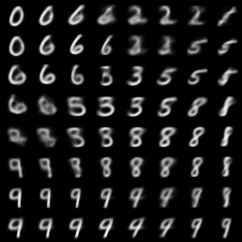

In [73]:
from torchvision.utils import make_grid
from google.colab.patches import cv2_imshow

with torch.no_grad():
    x = np.linspace(-0.9, 0.9, 8)
    y = np.linspace(-0.9, 0.9, 8)
    X, Y = np.meshgrid(x, y)
    z = torch.Tensor(np.vstack((X.flatten(), Y.flatten())).T).to(device)
    # z = torch.randn(64, 2).to(device)

    sample = F.sigmoid(model.decoder(z)).cpu()

img = make_grid(sample.view(64, 1, 28, 28)).numpy() * 255
cv2_imshow(img.transpose([1,2,0]))